Trial 10 Complete [00h 05m 34s]
val_accuracy: 0.3841666678587596

Best val_accuracy So Far: 0.40450000762939453
Total elapsed time: 00h 49m 37s
Epoch 1/25
782/782 [==============================] - 7s 8ms/step - loss: 1.2413 - accuracy: 0.6419 - val_loss: 2.5126 - val_accuracy: 0.4220 - lr: 0.0010
Epoch 2/25
 21/782 [..............................] - ETA: 3s - loss: 1.0331 - accuracy: 0.6949

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


782/782 [==============================] - 5s 6ms/step - loss: 1.1512 - accuracy: 0.6646 - val_loss: 2.5804 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 3/25
782/782 [==============================] - 5s 6ms/step - loss: 1.0674 - accuracy: 0.6852 - val_loss: 2.6999 - val_accuracy: 0.4087 - lr: 0.0010
Epoch 4/25
782/782 [==============================] - 5s 6ms/step - loss: 0.9991 - accuracy: 0.7001 - val_loss: 2.7928 - val_accuracy: 0.4071 - lr: 0.0010
Epoch 5/25
782/782 [==============================] - 4s 6ms/step - loss: 0.7465 - accuracy: 0.7741 - val_loss: 2.8415 - val_accuracy: 0.4196 - lr: 2.0000e-04
Epoch 6/25
313/313 [==============================] - 1s 3ms/step


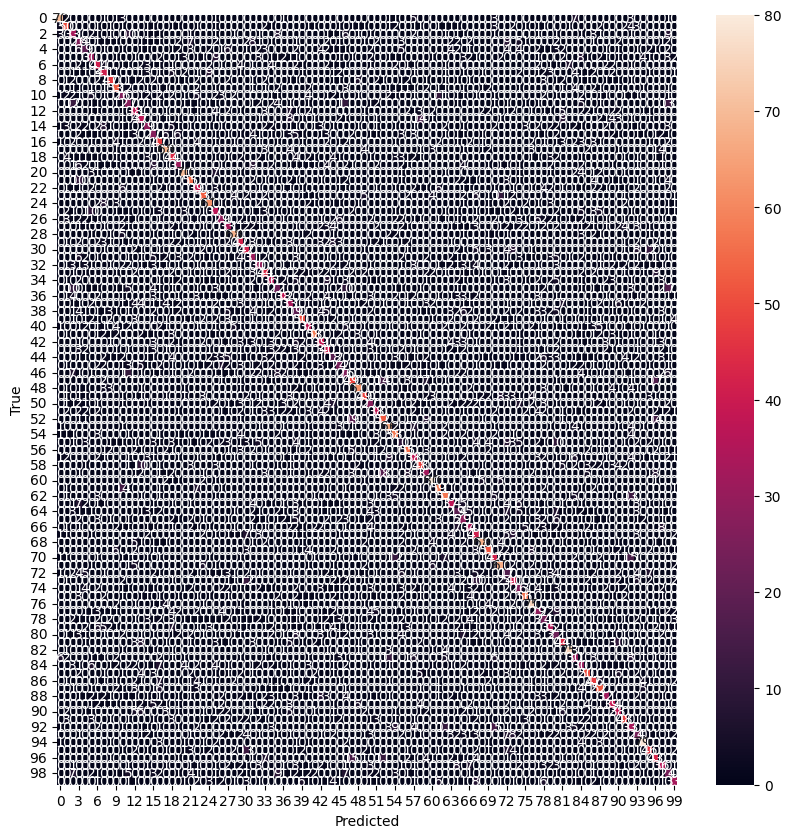

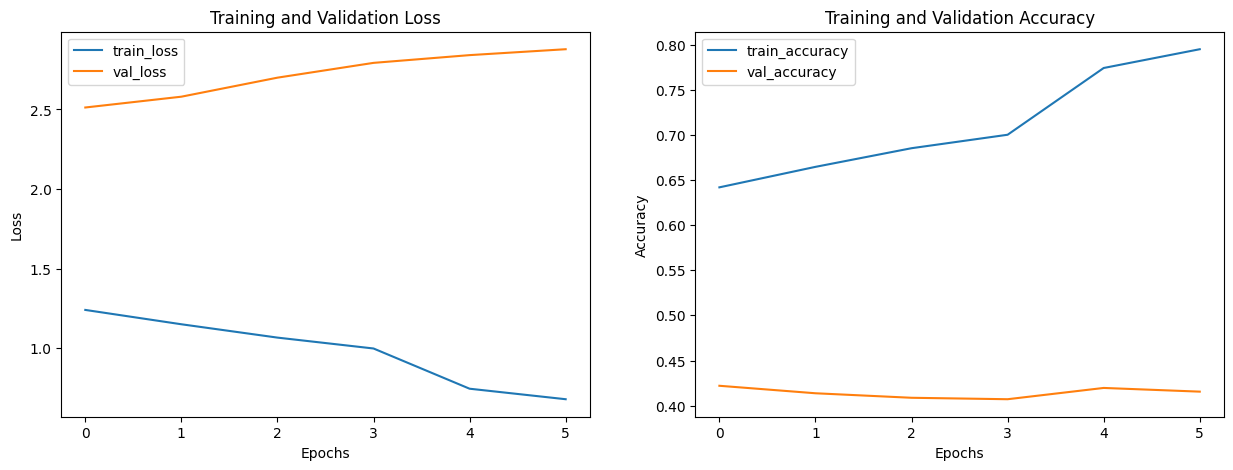

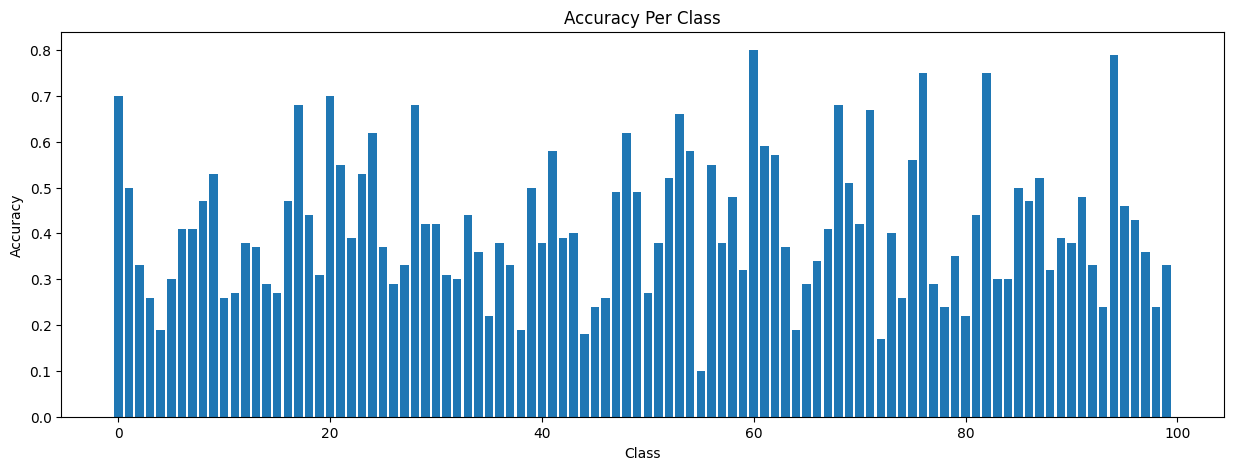

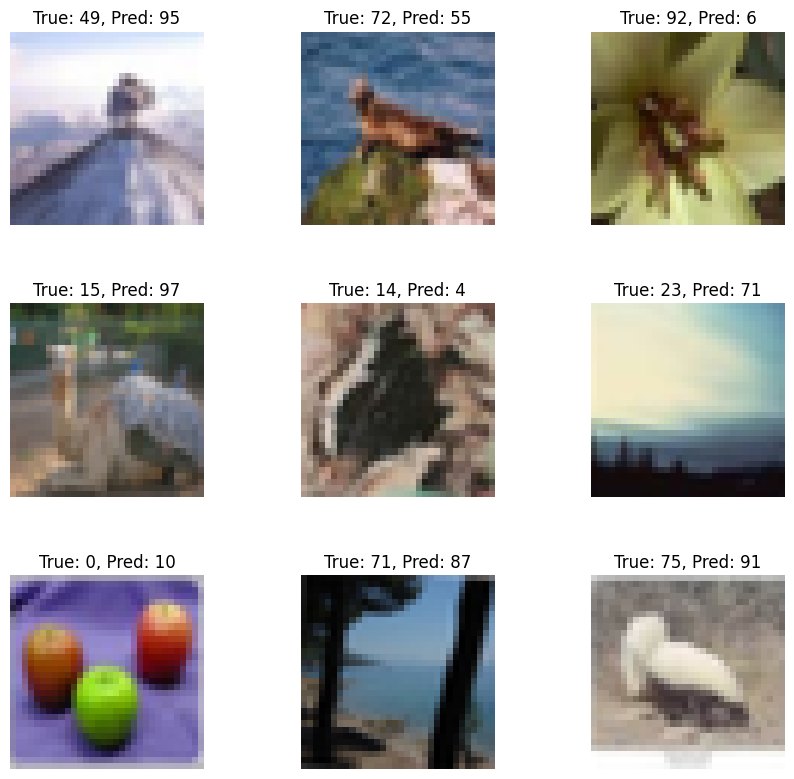

In [6]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize data
x_train, x_test = x_train / 255.0, x_test / 255.0

# Convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, 100)
y_test = tf.keras.utils.to_categorical(y_test, 100)

# Build a simple CNN model
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(100, activation='softmax')
    ])
    return model

model = create_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the CNN model
history = model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_acc}')

# Use Grid Search to optimize hyperparameters
!pip install keras-tuner
from kerastuner.tuners import RandomSearch

def build_model(hp):
    model = Sequential()
    model.add(Conv2D(hp.Int('conv_1', min_value=32, max_value=128, step=32), (3, 3), activation='relu', input_shape=(32, 32, 3)))
    model.add(MaxPooling2D((2, 2)))

    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv2D(hp.Int(f'conv_{i+2}', min_value=32, max_value=128, step=32), (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=128, max_value=512, step=128), activation='relu'))
    model.add(Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)))
    model.add(Dense(100, activation='softmax'))

    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=3,
    directory='my_dir',
    project_name='cifar100')

tuner.search(x_train, y_train, epochs=10, validation_data=(x_test, y_test))
best_model = tuner.get_best_models(num_models=1)[0]

# Use callback functions for automated training
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

callbacks = [reduce_lr, early_stopping, model_checkpoint]

history = best_model.fit(x_train, y_train, epochs=25, batch_size=64, validation_data=(x_test, y_test), callbacks=callbacks)

# Generate confusion matrix plot
y_pred = best_model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot training and testing loss and accuracy
def plot_metrics(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history.history['loss'], label='train_loss')
    ax1.plot(history.history['val_loss'], label='val_loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot accuracy
    ax2.plot(history.history['accuracy'], label='train_accuracy')
    ax2.plot(history.history['val_accuracy'], label='val_accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.show()

plot_metrics(history)

# Additional visualizations
# Visualization 1: Accuracy Per Class
accuracy_per_class = conf_matrix.diagonal() / conf_matrix.sum(axis=1)

plt.figure(figsize=(15, 5))
plt.bar(range(100), accuracy_per_class)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Accuracy Per Class')
plt.show()

# Visualization 2: Misclassified Images
misclassified_idx = np.where(y_pred_classes != y_true)[0]
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.ravel()

for i in np.arange(0, 9):
    idx = misclassified_idx[i]
    axes[i].imshow(x_test[idx])
    axes[i].set_title(f'True: {y_true[idx]}, Pred: {y_pred_classes[idx]}')
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)
plt.show()